In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import os
import time
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Order for Loading Data
1. Import necessary Libraries
2. Import Data
3. Write or instantiate Dataset object--some for image, some for sound, csv etc
4. Pass instantiated object into dataloader

In [2]:
#Import
#! consol command
#-q quiet, suppresses output
!unzip -q "archive (7).zip"

In [3]:
#Class to represent Data Set--subclass of imported dataset class
class EmotionDataset(Dataset):
  #Static declaration
  #Surprise entered as suprise in dataset
  classes=["Angry","Fear","Happy","Neutral","Sad","Suprise"]
  numclasses=6

  #Pass in path to inner testing training folders--use parameter "root"
  def __init__(self, root):
    super().__init__()
    self.root=root
    #Instance variable lists--file paths, lables, loops-can be overwritten for specific instance see self.classes
    self.filepath=[]
    self.filelabel=[]
    for index, label in enumerate(self.classes):
      #Joins multiple path commponents into one, agnostic to OS
      labeldatapath=os.path.join(root,label)
      #Return list of files and directories in called folder
      filenames=os.listdir(labeldatapath)
      #Path from current directory to file--join labeldatapath with file name
      #Without List Comprehension
      #for filename in filenames:
          #Construct full relative path
          #self.filepath.append(os.path.join(labeldatapath,filename))
          #Append index so classes have numbers
          #self.filelabel.append(index)
          #With List Comprehension
    self.filepath+=[os.path.join(labeldatapath,filename) for filename in filenames]
    self.filelabel+=[index]*len(filenames)

  def __getitem__(self, index):
    return torchvision.io.read_image(self.filepath[index]),torch.tensor(self.filelabel[index])
  def __len__(self):
    return len(self.filepath)

In [ ]:
#Instantiate Train and Test DataSets then feed into DataLoader
#Root Directory at the Splits Builds INdex
training_ds=EmotionDataset("Training/Training")
testing_ds=EmotionDataset("Testing/Testing")

train_dataloader=DataLoader(training_ds, batch_size=4,shuffle=True)
testing_dataloader=DataLoader(testing_ds, batch_size=4,shuffle=False)

for images,labels in train_dataloader:
  print(images.size())
  print(labels.size())
  break

torch.Size([4, 1, 48, 48])
torch.Size([4])


In [ ]:
#Squeeze and Excitation block for the CNN with Squeeze and Excitation network implementation:
#HELPER CLASS#
class SEBlock(nn.Module):
  def __init__(self, in_channels, reduction_ratio=16):
    super(SEBlock, self).__init__()
    self.global_pooling = nn.AdaptiveAvgPool2d(1)
    self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
    self.relu = nn.ReLU(inplace=True)
    self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
    self.sigmoid = nn.Sigmoid()

  #Forward pass
  def forward(self, x):
    x_sq = self.global_pooling(x).view(x.size(0), -1)

    x_sq = self.fc1(x_sq)
    x_sq = self.relu(x_sq)
    x_sq = self.fc2(x_sq)
    x_sq = self.sigmoid(x_sq).view(x.size(0), -1, 1, 1)

    return x * x_sq

In [ ]:
#Convolution with Squeeze and Excitation block implementation:
class CNNWithSE(nn.Module):
  def __init__(self, num_classes):
    super(CNNWithSE, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.se1 = SEBlock(128) #Selecting 128 channels which is the output of previous convolution layer for squeezing and exciting.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(128 * 12 * 12, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.pool(nn.functional.relu(self.conv1(x)))
    x = self.pool(nn.functional.relu(self.conv2(x)))
    x = self.se1(x)
    x = x.view(x.size(0), -1)
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
model = CNNWithSE(num_classes=6)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

############
##TRAINING##
############
timeStart = time.time()
num_epochs = 10
training_losses = []
training_accuracies = []
for epoch in range(num_epochs):
  model.train()
  running_loss_training = 0.0
  correct_predictions_train = 0
  total_samples_train = 0
  for images, labels in train_dataloader:
    optimizer.zero_grad()
    images = images.float()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss_training += loss.item()
    _, predicted_labels = torch.max(outputs, 1)
    total_samples_train += labels.size(0)
    correct_predictions_train += (predicted_labels == labels).sum().item()

  training_loss = running_loss_training / len(train_dataloader)
  training_accuracy = 100 * correct_predictions_train / total_samples_train
  training_losses.append(training_loss)
  training_accuracies.append(training_accuracy)

  print(f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%")

timeEnd = time.time()
elapsedTimeInSec = timeEnd - timeStart
print("Training Execution Time: {:.3f} seconds".format(elapsedTimeInSec))

###########
##TESTING##
###########
timeStart = time.time()
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in testing_dataloader:
    images = images.float()
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {(100 * correct / total):.2f}%')

timeEnd = time.time()
elapsedTimeInSec = timeEnd - timeStart
print("Testing Execution Time: {:.3f} seconds".format(elapsedTimeInSec))

Epoch [1/10] - Training Loss: 0.0001, Training Accuracy: 100.00%
Epoch [2/10] - Training Loss: 0.0000, Training Accuracy: 100.00%
Epoch [3/10] - Training Loss: 0.0000, Training Accuracy: 100.00%
Epoch [4/10] - Training Loss: 0.0000, Training Accuracy: 100.00%
Epoch [5/10] - Training Loss: 0.0000, Training Accuracy: 100.00%
Epoch [6/10] - Training Loss: 0.0000, Training Accuracy: 100.00%
Epoch [7/10] - Training Loss: 0.0000, Training Accuracy: 100.00%
Epoch [8/10] - Training Loss: 0.0000, Training Accuracy: 100.00%
Epoch [9/10] - Training Loss: 0.0000, Training Accuracy: 100.00%
Epoch [10/10] - Training Loss: 0.0000, Training Accuracy: 100.00%
Training Execution Time: 193.439 seconds
Accuracy on the test set: 100.00%
Testing Execution Time: 0.917 seconds


<Figure size 640x480 with 0 Axes>

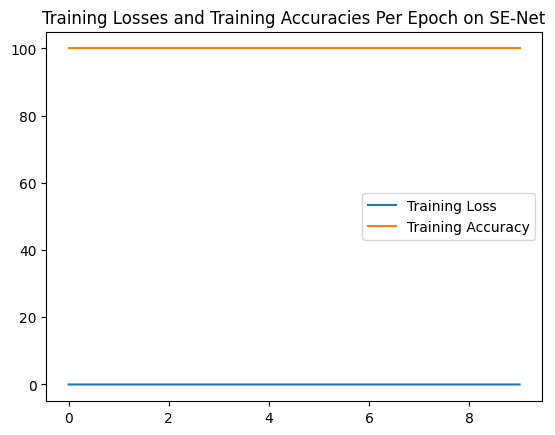

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.title("Training Losses and Training Accuracies Per Epoch on SE-Net")
plt.plot(training_losses)
plt.plot(training_accuracies)
plt.legend(['Training Loss','Training Accuracy'],loc=5)
plt.figure()

#confusion_se=confusion_matrix(labels,correct)

